In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import os
import sys
import json

import numpy as np
import pandas as pd


from matplotlib import rcParams
from matplotlib import font_manager
%matplotlib inline



In [3]:
# resource configuration
rcParams['figure.dpi'] = 200

# fount information
rcParams['font.family'] = 'Equinor'
rcParams['font.size'] = 9

# fornt location
font_path = r'Equinor_regular'
font_files = font_manager.findSystemFonts(fontpaths=font_path)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [4]:
from ecl.eclfile import EclFile
from ecl.eclfile import EclInitFile, EclRestartFile
from ecl.grid import EclGrid
#import rips 

In [5]:
# display all columns
pd.set_option('display.max_columns', None)

In [6]:
# where WellClass and Ga[ codes are located
sys.path.append('../src')

In [7]:
# GaP
from GaP.libs.models import (
    PipeCementModel,
    ElemModel,
    DepthModel,
)

from GaP.libs.carfin import build_grdecl

In [8]:
# WellClass
# from well_class_v2 import csv_parser, Well
from WellClass.libs.utils import (
    csv_parser,
    yaml_parser,
)
from WellClass.libs.well_class import Well

from WellClass.libs.utils.LGR_grid import (
    compute_ngrd,
    generate_LGR_xy,
    generate_LGR_z,
)

from WellClass.libs.plotting import plot_well_perm

## Some user options

In [9]:
# TODO(hzh): use Ali's algorithm
Ali_way = True

In [10]:
# use yaml or csv input file
use_yaml = True

In [11]:
# pick an example from given three options

case_type = 'cosmo'

case_type = 'smeaheia_v1'

# case_type = 'smeaheia_v2'

# Examples

The following are the test examples.

In [12]:
# examples
smeaheia_v1 = {'well_input': r'GaP_input_Smeaheia_v3.csv', 
               'well_input_yaml': r'smeaheia.yaml', 
            #    'sim_path': r'/scratch/SCS/eim/SMEAHEIA', 
               'sim_path': r'../test_data/examples/smeaheia_v1',
               'simcase': r'GEN_NOLGR_PH2'}
smeaheia_v2 = {'well_input': r'GaP_input_Smeaheia_v3.csv', 
               'well_input_yaml': r'smeaheia.yaml', 
            #    'sim_path': r'/scratch/SCS/bkh/wbook/realization-0/iter-0/pflotran/model', 
               'sim_path': r'../test_data/examples/smeaheia_v2', 
               'simcase': r'TEMP-0'}
cosmo = {
         'well_input': r'GaP_input_Cosmo_v3.csv', 
         'well_input_yaml': r'cosmo.yaml', 
        #  'sim_path': r'/scratch/SCS/bkh/well_class_test1/realization-0/iter-0/pflotran/model', 
         'sim_path': r'../test_data/examples/cosmo', 
         'simcase': r'TEMP-0'}

In [13]:
examples = {
    'smeaheia_v1': smeaheia_v1,
    'smeaheia_v2': smeaheia_v2,
    'cosmo': cosmo
}

# Load well CSV or yaml configuration file

Process CSV with well class.
Predefine a dictionary that includes the input CSV well file, the simulation path, and the PFT sim case name

In [14]:
# the selected example for testing
case = examples[case_type]


In [15]:

# root_path = '/scratch/SCS/gpb/SCREEN/GaP_code'

# where the location for the input parameters and eclipse .EGRID and .INIT files
sim_path = case['sim_path']


In [16]:
if use_yaml:
    # where well configuration file is located
    well_name = os.path.join(sim_path, case['well_input_yaml'])
    
    # # pydantic model
    well_model = yaml_parser(well_name)
    well_csv = json.loads(well_model.spec.model_dump_json())
else:
    # where well configuration file is located
    well_name = os.path.join(sim_path, case['well_input'])

    # load the well information
    well_csv = csv_parser(well_name)

In [17]:
#Process well by running well class
my_well = Well( header       = well_csv['well_header'], 
                drilling     = well_csv['drilling'],
                casings      = well_csv['casing_cement'],
                geology      = well_csv['geology'],
                barriers     = well_csv['barriers'], 
                barrier_perm = well_csv['barrier_permeability'],
                co2_datum    = well_csv['co2_datum'],
           )

# Loading the model

- Load the PFT grid, init and restart files.
- Grid contains geometry specs
- INIT contains static properties (i.e. poro., perm., transmissibilities)
- RST contains dynamic properties (i.e. saturations, pressure)


In [18]:
# simulation case without legacy well 

# path = '/scratch/SCS/bkh/wbook/realization-0/iter-0/pflotran/model'

# location of .egrid
simcase = os.path.join(sim_path, case['simcase'])

#Get grid dimensions and coordinates
grid = EclGrid(simcase + ".EGRID") 
#init = EclGrid(simcase + ".INIT") 
init = EclInitFile(grid, simcase + ".INIT")
# restart file
# rst = EclRestartFile(grid, simcase + ".UNRST")

## The grid dimensions

In [19]:
NX, NY, NZ, total = grid.get_dims()
NX, NY, NZ, total

(20, 20, 82, 32800)

## Analysis of init grid info

In [20]:
init.keys()

dict_keys(['SEQNUM', 'INTEHEAD', 'LOGIHEAD', 'DOUBHEAD', 'PORV', 'DX', 'DY', 'DZ', 'PERMX', 'PERMY', 'PERMZ', 'MULTX', 'MULTY', 'MULTZ', 'MULTX-', 'MULTY-', 'MULTZ-', 'TRANX', 'TRANY', 'TRANZ', 'PORO', 'DEPTH', 'NTG'])

In [21]:
init['DZ']

[EclKW(size=32800, name="DZ", min=5.00, max=308.00) at 0x55dcf9090b30]

In [22]:
aa = init['DZ'][0].numpy_view()
aa.shape

(32800,)

In [23]:
# init['DZ'][1].numpy_view()

# Store INIT parameters into a Pandas Dataframe: grid_init

In [24]:
grid_init = grid.export_index()

In [25]:
# Static properties Dataframe
for key in init.keys():
        try:
                grid_init[key] = init[key][0].numpy_view()
        except:
                continue

In [26]:
#Create cell coordinate X, Y, Z

# generate cell coordinates by shifting half cell size
xcoord = (grid_init.query("j==0&k==0").DX.cumsum() - grid_init.query("j==0&k==0").DX/2).values
ycoord = (grid_init.query("i==0&k==0").DY.cumsum() - grid_init.query("i==0&k==0").DY/2).values
zcoord = (grid_init.query("i==0&j==0").DZ.cumsum() - grid_init.query("i==0&j==0").DZ/2).values

# TODO(hzh): a bug?
# map_X = dict(zip(grid_init.query("j==0&j==0")['i'], xcoord))
map_X = dict(zip(grid_init.query("j==0&k==0")['i'], xcoord))
map_Y = dict(zip(grid_init.query("i==0&k==0")['j'], ycoord))
map_Z = dict(zip(grid_init.query("i==0&j==0")['k'], zcoord))

# save cell coordinates to DataFrame
grid_init['X'] = grid_init['i'].map(map_X)
grid_init['Y'] = grid_init['j'].map(map_Y)
grid_init['Z'] = grid_init['k'].map(map_Z)

In [27]:
grid_init.tail()

,i,j,k,active,PORV,DX,DY,DZ,PERMX,PERMY,PERMZ,MULTX,MULTY,MULTZ,MULTX-,MULTY-,MULTZ-,TRANX,TRANY,TRANZ,PORO,DEPTH,NTG,X,Y,Z
32795,15,19,81,32795,120000.0,200.0,200.0,10.0,0.01,0.01,0.001,1.0,1.0,1.0,1.0,1.0,1.0,0.000853,0.0,0.0,0.3,1617.0,1.0,3100.0,3900.0,1613.0
32796,16,19,81,32796,120000.0,200.0,200.0,10.0,0.01,0.01,0.001,1.0,1.0,1.0,1.0,1.0,1.0,0.000853,0.0,0.0,0.3,1617.0,1.0,3300.0,3900.0,1613.0
32797,17,19,81,32797,120000.0,200.0,200.0,10.0,0.01,0.01,0.001,1.0,1.0,1.0,1.0,1.0,1.0,0.000853,0.0,0.0,0.3,1617.0,1.0,3500.0,3900.0,1613.0
32798,18,19,81,32798,120000.0,200.0,200.0,10.0,0.01,0.01,0.001,1.0,1.0,1.0,1.0,1.0,1.0,0.000853,0.0,0.0,0.3,1617.0,1.0,3700.0,3900.0,1613.0
32799,19,19,81,32799,120000.0,200.0,200.0,10.0,0.01,0.01,0.001,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.0,0.0,0.3,1617.0,1.0,3900.0,3900.0,1613.0


## Plot well sketch and 2D slice of the permeability, at coarse grid.

In [28]:
# middle indices of x and y
mid_i = grid_init.i.max()//2
mid_j = grid_init.j.max()//2

In [29]:
# generate grid coordinates for plotting

# grid coordinates
xcorn  = (grid_init.query("j==0&k==0").DX.cumsum()).values
ycorn  = (grid_init.query("i==0&k==0").DY.cumsum()).values
zcorn  = (grid_init.query("i==0&j==0").DZ.cumsum()).values

# add origin coordinates
xcorn = np.append(0, xcorn)
ycorn = np.append(0, ycorn)
zcorn = np.append(0, zcorn)

# shift grid coordinates half-length in x-y directions, i.e., [0, 3900] => [-1900, 2100]
xcorn -= xcoord[mid_i]
ycorn -= ycoord[mid_j]

In [30]:
xcoord[mid_i], xcorn[mid_i]

(1900.0, -100.0)

In [31]:
# extract 2D xz slice at middle of y
XZ_slice = grid_init.query('j==@mid_j')

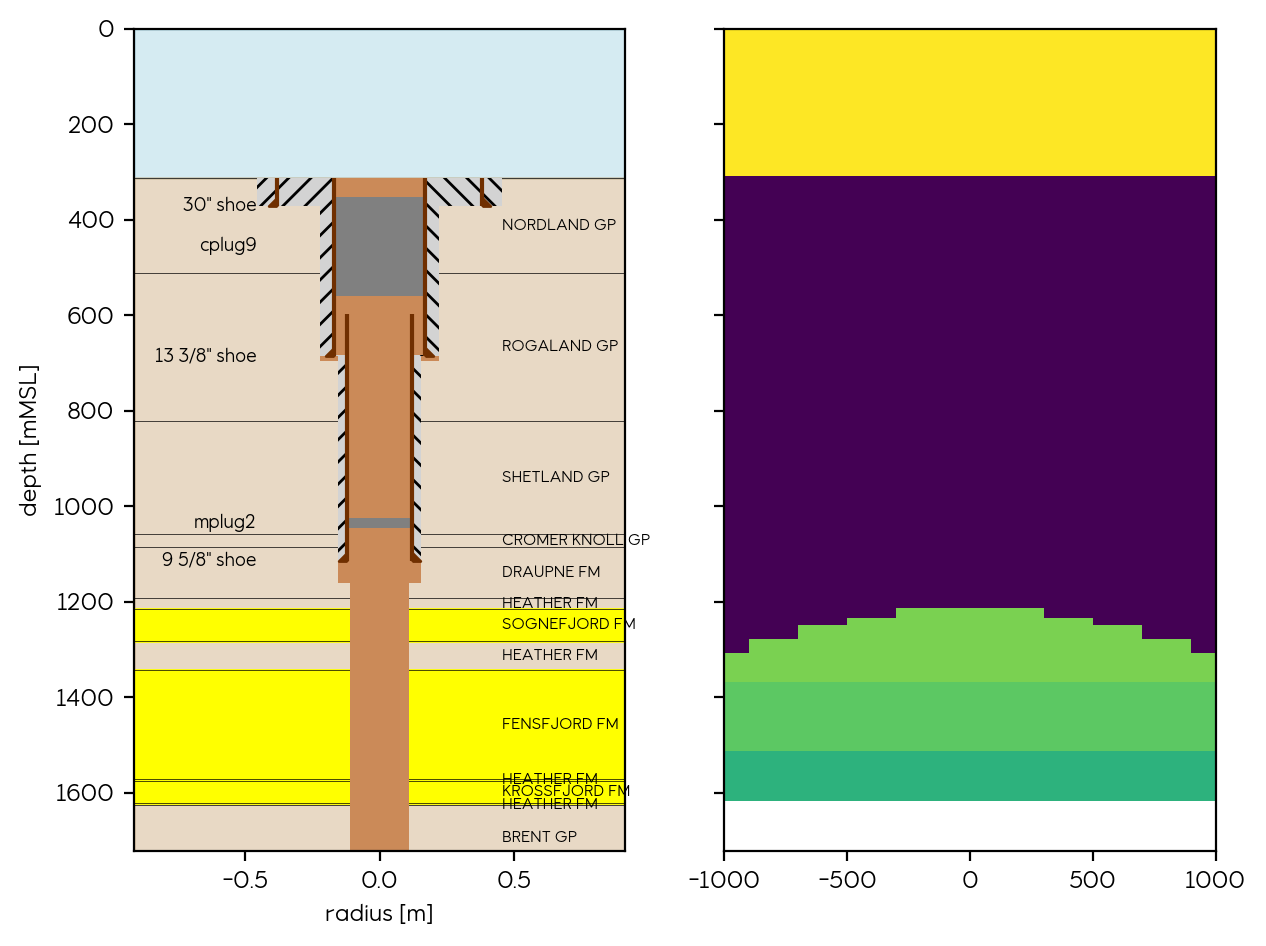

In [32]:
# extract permeability
Z = XZ_slice.PERMX.values.reshape(NZ, NX)

# plot x-z slice
plot_well_perm(my_well, x=xcorn, y=zcorn, Z=Z, on_coarse=True)

In [33]:
# Retrieve coarse x-y grid indexes where LGR will be placed

# TODO(hzh): 
#   1) why switch i and j? 
main_grd_i     = grid_init.j.max()//2
main_grd_j     = grid_init.i.max()//2

# Rettrieve min and max k-index for column where LGR will be placed
# TODO(hzh): Do I need to add 1 here?
main_grd_min_k = grid_init.k.min()
main_grd_max_k = grid_init.k.max()

In [34]:
main_grd_i, main_grd_j, main_grd_min_k, main_grd_max_k

(9, 9, 0, 81)

In [35]:
# Retrieve coarse cell sizes
main_grd_dx = grid_init.query('i == @main_grd_i & j == @main_grd_j & k == k.min()')['DX'].iloc[0]
main_grd_dy = grid_init.query('i == @main_grd_i & j == @main_grd_j & k == k.min()')['DY'].iloc[0]

main_grd_dx, main_grd_dy

(200.0, 200.0)

In [36]:

# Retrieve all DZ in coarse grid, not used
main_DZ = grid_init.query('i == @main_grd_i & j == @main_grd_j')['DZ'].values

main_DZ, len(main_DZ), 

(array([308., 100., 100., 100., 100., 100., 100., 100., 100., 100.,   5.,
          5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,
          5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,
          5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,
          5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,
          5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,
          5.,   5.,   5.,   5.,   5.,   5.,  10.,  10.,  10.,  10.,  10.,
         10.,  10.,  10.,  10.,  10.], dtype=float32),
 82)

In [37]:
main_DEPTH = grid_init.query('i == @main_grd_i & j == @main_grd_j')['DEPTH'].values
main_DEPTH

array([ 158. ,  362. ,  462. ,  562. ,  662. ,  762. ,  862. ,  962. ,
       1062. , 1162. , 1214.5, 1219.5, 1224.5, 1229.5, 1234.5, 1239.5,
       1244.5, 1249.5, 1254.5, 1259.5, 1264.5, 1269.5, 1274.5, 1279.5,
       1284.5, 1289.5, 1294.5, 1299.5, 1304.5, 1309.5, 1314.5, 1319.5,
       1324.5, 1329.5, 1334.5, 1339.5, 1344.5, 1349.5, 1354.5, 1359.5,
       1364.5, 1369.5, 1374.5, 1379.5, 1384.5, 1389.5, 1394.5, 1399.5,
       1404.5, 1409.5, 1414.5, 1419.5, 1424.5, 1429.5, 1434.5, 1439.5,
       1444.5, 1449.5, 1454.5, 1459.5, 1464.5, 1469.5, 1474.5, 1479.5,
       1484.5, 1489.5, 1494.5, 1499.5, 1504.5, 1509.5, 1514.5, 1519.5,
       1527. , 1537. , 1547. , 1557. , 1567. , 1577. , 1587. , 1597. ,
       1607. , 1617. ], dtype=float32)

In [38]:
# depth where LGR starts
ref_depth = 0
if Ali_way:
    ref_depth = main_DEPTH[0] - 0.5*main_DZ[0]
    

In [39]:
ref_depth

4.0

In [40]:
#Retrieve number of cells representing water column and overburden
no_of_layers_in_OB    = grid_init.query('i==@main_grd_i & j == @main_grd_j & DZ >  10')['DZ'].shape[0]
no_of_layers_below_OB = grid_init.query('i==@main_grd_i & j == @main_grd_j & DZ <= 10')['DZ'].shape[0]

no_of_layers_in_OB, no_of_layers_below_OB

(10, 72)

# drilling, casings, borehole and barriers

In [41]:
# dataframes for the well
drilling_df = pd.DataFrame(my_well.drilling)
casings_df = pd.DataFrame(my_well.casings)
borehole_df = pd.DataFrame(my_well.borehole)

barriers_df = pd.DataFrame(my_well.barriers)
barriers_mod_df = pd.DataFrame(my_well.barriers_mod)

In [42]:
drilling_df

,top_rkb,bottom_rkb,diameter_in,diameter_m,top_msl,bottom_msl
0,335.5,395.0,36.00,0.91440,312.0,371.5
1,395.0,720.0,17.50,0.44450,371.5,696.5
2,720.0,1185.0,12.25,0.31115,696.5,1161.5
3,1185.0,3186.0,8.50,0.21590,1161.5,3162.5


In [43]:
casings_df

,top_rkb,bottom_rkb,diameter_in,toc_rkb,boc_rkb,shoe,diameter_m,top_msl,bottom_msl,toc_msl,boc_msl
0,335.5,394.0,30.000,335.5,394.0,True,0.762000,312.0,370.5,312.0,370.5
1,335.5,709.0,13.375,335.5,709.0,True,0.339725,312.0,685.5,312.0,685.5
2,622.0,1137.5,9.625,706.0,1137.5,True,0.244475,598.5,1114.0,682.5,1114.0


In [44]:
barriers_mod_df

,b_name,top_msl,bottom_msl,diameter_m
cplug9_0,cplug9,351.5,559.5,0.339725
mplug2_1,mplug2,1025.5,1045.5,0.244475


In [45]:
# Compute annulus thickness. 
# For simplicty it assumes annulus between casing and openhole as entire annulus

casings_df['ann_od_m'] = np.nan
casings_df['ann_bottom_msl'] = np.nan

# casing
for idx, row in casings_df[::-1].iterrows():

        # get id from casing
        d, top, bottom = row[['diameter_m', 'top_msl', 'bottom_msl']]

        # get od from drilling
        hole = drilling_df[drilling_df['diameter_m'] > d].iloc[-1]
    
        hole_top, hole_bottom, hole_d = hole[['top_msl', 'bottom_msl', 'diameter_m']]

        casings_df.loc[idx, 'ann_od_m'] = hole_d       # outer diameter in meters
        casings_df.loc[idx, 'ann_bottom_msl'] = hole_bottom

#Compute inner area
casings_df['A_i'] = np.pi * (casings_df['diameter_m']/2)**2

#Compute outer area
casings_df['A_o'] = np.pi * (casings_df['ann_od_m']/2)**2

# annulus thickness: (od-id)/2
casings_df['thick_m'] = (casings_df['ann_od_m'] - casings_df['diameter_m'])/2

In [46]:
casings_df

,top_rkb,bottom_rkb,diameter_in,toc_rkb,boc_rkb,shoe,diameter_m,top_msl,bottom_msl,toc_msl,boc_msl,ann_od_m,ann_bottom_msl,A_i,A_o,thick_m
0,335.5,394.0,30.000,335.5,394.0,True,0.762000,312.0,370.5,312.0,370.5,0.91440,371.5,0.456037,0.656693,0.076200
1,335.5,709.0,13.375,335.5,709.0,True,0.339725,312.0,685.5,312.0,685.5,0.44450,696.5,0.090645,0.155179,0.052388
2,622.0,1137.5,9.625,706.0,1137.5,True,0.244475,598.5,1114.0,682.5,1114.0,0.31115,1161.5,0.046942,0.076038,0.033337


# LGR grid utility functions

In [47]:
def get_k_indices(df, top, bottom):
        """
        Takes the mesh data frame and a value of top and bottom depth interval.
        Returns the min and max k indexes
        """
    
        # k_min
        if top <= df['Zcorn_top'].min():
            
                k_min = df['k'].min()
            
        elif top in df['Zcorn_top'].values:
            
                k_min = df.query('Zcorn_top==@top & Zcorn_bottom>=@top')['k'].iloc[0]
        else:
                k_min = df.query('Zcorn_top<=@top & Zcorn_bottom>=@top')['k'].iloc[0]

        # k_max
        if bottom >= df['Zcorn_bottom'].max():
            
                k_max = df['k'].max()

        elif bottom in df['Zcorn_bottom'].values:
                # print(bottom)
                k_max = df.query('Zcorn_top<=@bottom & Zcorn_bottom==@bottom')['k'].iloc[0]
        else:
                k_max = df.query('Zcorn_top<=@bottom & Zcorn_bottom>=@bottom')['k'].iloc[0]


        return k_min, k_max

## LGR grid information in x, y, z directions

We are going to compute the grid sizes in lateral (x and y) and vertical directions

### Compute minimum grid size

In [48]:
# 0. minimum grid size

# minimum grid size depends on minimum annulus thickness
min_grd_size = casings_df['thick_m'].min()

if min_grd_size < 0.05:
    min_grd_size = 0.05

print(f'Minimimum grid size is {min_grd_size*100:.2f} cm')

Minimimum grid size is 5.00 cm


In [49]:
# TODO(hzh): manually set it
if Ali_way:
    min_grd_size = 0.05

In [50]:
# 1. compute number of LGR grids for drilling, casing and borehole, respectively

# for drilling
drilling_df['n_grd_id']  = drilling_df['diameter_m'].map(lambda x: compute_ngrd(x, min_grd_size))

# the following two are not used
casings_df[ 'n_grd_id']  = casings_df['diameter_m'].map(lambda x: compute_ngrd(x, min_grd_size))
borehole_df['n_grd_id'] = borehole_df['id_m'].map(lambda x: compute_ngrd(x, min_grd_size))

### Compute LGR grid sizes in x-y directions

In [51]:
# 2. compute LGR grid sizes in x-y directions

# 2.1 Number of cells representing horizontal LGR
no_latral_fine_grd = drilling_df['n_grd_id'].max()
no_latral_fine_grd

16

In [52]:
# 2.2 generate the LGR grid sizes in x-y
LGR_sizes_x, LGR_sizes_y, _ = generate_LGR_xy(no_latral_fine_grd, 
                                              min_grd_size, 
                                              main_grd_dx, main_grd_dy,
                                              Ali_way=Ali_way)

In [53]:
LGR_sizes_x, len(LGR_sizes_x)

([94.0,
  5.0,
  0.5,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.5,
  5.0,
  94.0],
 26)

### Compute LGR grid sizes in z direction

In [54]:
# 3. Compute LGR grid sizes in z direction

# the dz value to distinguish zones between reservoir and ovb
dz0 = 10

# 3.1 DZs for reservoir
DZ_rsrv = grid_init.query('i==@main_grd_i & j == @main_grd_j & DZ <= @dz0')['DZ'].values

# 3.2 DZs for coarse grid
DZ_ovb_coarse = grid_init.query('i==@main_grd_i & j == @main_grd_j & DZ > @dz0')['DZ'].values

# 3.3 generate the LGR grid sizes in z
# LGR_sizes_z, LGR_numb_z, LGR_depths, _ = generate_LGR_z(DZ_rsrv, DZ_ovb_coarse)
# TODO(hzh): to make LGR starts at ref_depth
LGR_sizes_z, LGR_numb_z, LGR_depths, _ = generate_LGR_z(DZ_rsrv, DZ_ovb_coarse, ref_depth)

In [55]:
LGR_sizes_z, LGR_sizes_z.shape[0]

(array([34.8, 30.8, 30.8, 30.8, 30.8, 30.8, 30.8, 30.8, 30.8, 30.8, 10. ,
        10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. ,
        10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. ,
        10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. ,
        10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. ,
        10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. ,
        10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. ,
        10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. ,
        10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. ,
        10. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,
         5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,
         5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,
         5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,
         5. ,  5. ,  5. ,  5. ,  5. , 

In [56]:
LGR_numb_z, LGR_depths

(array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]),
 array([  34.8     ,   65.6     ,   96.399994,  127.2     ,  158.      ,
         188.8     ,  219.6     ,  250.40001 ,  281.2     ,  312.      ,
         322.      ,  332.      ,  342.      ,  352.      ,  362.      ,
         372.      ,  382.      ,  392.      ,  402.      ,  412.      ,
         422.      ,  432.      ,  442.      ,  452.      ,  462.      ,
         472.      ,  482.      ,  492.      ,  502.      ,  512.      ,
         522.      ,  532.      ,  542.      ,  552.      ,  562.      ,
         572.      ,  582.      ,  592.      ,  602.      ,  612.      ,
         622.      ,  632.      ,  642.      ,

In [57]:
# LGR dimensions
nx = len(LGR_sizes_x)
ny = len(LGR_sizes_y)
nz = len(LGR_sizes_z)

nx, ny, nz

(26, 26, 172)

# Dataframe for LGR mesh

In [58]:
#Create i, j, k indices
cell_ijk = np.indices((nx, ny, nz))
cell_ijk = cell_ijk.reshape((3, nx * ny * nz)).T

In [59]:
#Create LGR Dataframe with indices
mesh_df = pd.DataFrame(data = cell_ijk, columns = ['i', 'j', 'k'])

mesh_df.sort_values(by=['k', 'i'], inplace = True)
mesh_df.reset_index(inplace=True, drop=True)

In [60]:
#Creat DX, DY, DZ for LGR mesh
DX_grid, DZ_grid, DY_grid = np.meshgrid(LGR_sizes_x, LGR_sizes_z, LGR_sizes_y)

mesh_df['DX'] = DX_grid.flatten()
mesh_df['DY'] = DY_grid.flatten()
mesh_df['DZ'] = DZ_grid.flatten()

In [61]:
mesh_df.head()

,i,j,k,DX,DY,DZ
0,0,0,0,94.0,94.00,34.799999
1,0,1,0,94.0,5.00,34.799999
2,0,2,0,94.0,0.50,34.799999
3,0,3,0,94.0,0.05,34.799999
4,0,4,0,94.0,0.05,34.799999


In [62]:
#Create cell coordinate X, Y, Z for LGR mesh

# cell coordinates
xcoord = (mesh_df.query("j==0&k==0").DX.cumsum() - mesh_df.query("j==0&k==0").DX/2).values
ycoord = (mesh_df.query("i==0&k==0").DY.cumsum() - mesh_df.query("i==0&k==0").DY/2).values
zcoord = (mesh_df.query("i==0&j==0").DZ.cumsum() - mesh_df.query("i==0&j==0").DZ/2).values

# TODO(hzh): a bug?
# map_X = dict(zip(mesh_df.query("j==0&j==0")['i'], xcoord))
map_X = dict(zip(mesh_df.query("j==0&k==0")['i'], xcoord))
map_Y = dict(zip(mesh_df.query("i==0&k==0")['j'], ycoord))
map_Z = dict(zip(mesh_df.query("i==0&j==0")['k'], zcoord))

# save cell coordinates X, Y, Z to dataframe
mesh_df['X'] = mesh_df['i'].map(map_X)
mesh_df['Y'] = mesh_df['j'].map(map_Y)
mesh_df['Z'] = mesh_df['k'].map(map_Z)

In [63]:
# save Corner Z points to dataframe
mesh_df['Zcorn_top'] = mesh_df['Z'] - mesh_df['DZ']/2
mesh_df['Zcorn_bottom'] = mesh_df['Z'] + mesh_df['DZ']/2

In [64]:
mesh_df.tail()

,i,j,k,DX,DY,DZ,X,Y,Z,Zcorn_top,Zcorn_bottom
116267,25,21,171,94.0,0.05,10.0,153.0,100.425,1617.0,1612.0,1622.0
116268,25,22,171,94.0,0.05,10.0,153.0,100.475,1617.0,1612.0,1622.0
116269,25,23,171,94.0,0.50,10.0,153.0,100.750,1617.0,1612.0,1622.0
116270,25,24,171,94.0,5.00,10.0,153.0,103.500,1617.0,1612.0,1622.0
116271,25,25,171,94.0,94.00,10.0,153.0,153.000,1617.0,1612.0,1622.0


## Upscale coarse properties to LGR grids

In [65]:
# indices for center finer grid
mid_i = mesh_df.i.max()//2
mid_j = mesh_df.j.max()//2
mid_i, mid_j

(12, 12)

In [66]:
# properties
fields = ['PORV', 
          'PERMX', 'PERMY', 'PERMZ', 
          'MULTX', 'MULTY', 'MULTZ', 
          'MULTX-', 'MULTY-', 'MULTZ-', 
          'PORO']

In [67]:
# Upscale coarse properties to LGR grids

for field in fields:
    # mesh_df[field] = np.nan
    mesh_df[field] = 0.0                    # TODO(hzh): what should I put here?
    
for idx, row in grid_init.query('i==@mid_i & j==@mid_j').iterrows():

    # switch to corner coords, coarse grid
    top  = row.Z - row.DZ/2
    base = row.Z + row.DZ/2

    for field in fields:

        mesh_df.loc[(mesh_df['Z']>=top) & (mesh_df['Z']<base), field] = row[field]


In [68]:
mid_df = grid_init.query('i==@mid_i & j==@mid_j')
mid_df.tail()

,i,j,k,active,PORV,DX,DY,DZ,PERMX,PERMY,PERMZ,MULTX,MULTY,MULTZ,MULTX-,MULTY-,MULTZ-,TRANX,TRANY,TRANZ,PORO,DEPTH,NTG,X,Y,Z
31052,12,12,77,31052,92000.0,200.0,200.0,10.0,70.0,70.0,7.0,1.0,1.0,1.0,1.0,1.0,1.0,5.968912,5.968912,238.75647,0.23,1577.0,1.0,2500.0,2500.0,1573.0
31452,12,12,78,31452,92000.0,200.0,200.0,10.0,70.0,70.0,7.0,1.0,1.0,1.0,1.0,1.0,1.0,5.968912,5.968912,238.75647,0.23,1587.0,1.0,2500.0,2500.0,1583.0
31852,12,12,79,31852,92000.0,200.0,200.0,10.0,70.0,70.0,7.0,1.0,1.0,1.0,1.0,1.0,1.0,5.968912,5.968912,238.75647,0.23,1597.0,1.0,2500.0,2500.0,1593.0
32252,12,12,80,32252,92000.0,200.0,200.0,10.0,70.0,70.0,7.0,1.0,1.0,1.0,1.0,1.0,1.0,5.968912,5.968912,238.75647,0.23,1607.0,1.0,2500.0,2500.0,1603.0
32652,12,12,81,32652,92000.0,200.0,200.0,10.0,70.0,70.0,7.0,1.0,1.0,1.0,1.0,1.0,1.0,5.968912,5.968912,0.00000,0.23,1617.0,1.0,2500.0,2500.0,1613.0


In [69]:
mesh_df.tail(200)

,i,j,k,DX,DY,DZ,X,Y,Z,Zcorn_top,Zcorn_bottom,PORV,PERMX,PERMY,PERMZ,MULTX,MULTY,MULTZ,MULTX-,MULTY-,MULTZ-,PORO
116072,18,8,171,0.05,0.05,10.0,100.275,99.775,1617.0,1612.0,1622.0,92000.0,70.0,70.0,7.0,1.0,1.0,1.0,1.0,1.0,1.0,0.23
116073,18,9,171,0.05,0.05,10.0,100.275,99.825,1617.0,1612.0,1622.0,92000.0,70.0,70.0,7.0,1.0,1.0,1.0,1.0,1.0,1.0,0.23
116074,18,10,171,0.05,0.05,10.0,100.275,99.875,1617.0,1612.0,1622.0,92000.0,70.0,70.0,7.0,1.0,1.0,1.0,1.0,1.0,1.0,0.23
116075,18,11,171,0.05,0.05,10.0,100.275,99.925,1617.0,1612.0,1622.0,92000.0,70.0,70.0,7.0,1.0,1.0,1.0,1.0,1.0,1.0,0.23
116076,18,12,171,0.05,0.05,10.0,100.275,99.975,1617.0,1612.0,1622.0,92000.0,70.0,70.0,7.0,1.0,1.0,1.0,1.0,1.0,1.0,0.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116267,25,21,171,94.00,0.05,10.0,153.000,100.425,1617.0,1612.0,1622.0,92000.0,70.0,70.0,7.0,1.0,1.0,1.0,1.0,1.0,1.0,0.23
116268,25,22,171,94.00,0.05,10.0,153.000,100.475,1617.0,1612.0,1622.0,92000.0,70.0,70.0,7.0,1.0,1.0,1.0,1.0,1.0,1.0,0.23
116269,25,23,171,94.00,0.50,10.0,153.000,100.750,1617.0,1612.0,1622.0,92000.0,70.0,70.0,7.0,1.0,1.0,1.0,1.0,1.0,1.0,0.23
116270,25,24,171,94.00,5.00,10.0,153.000,103.500,1617.0,1612.0,1622.0,92000.0,70.0,70.0,7.0,1.0,1.0,1.0,1.0,1.0,1.0,0.23


# Assign open hole/open pipe cells in mesh

In [70]:
# initialize material to overburden
mesh_df['material'] = 'overburden'

## Drilling

In [71]:
# 1. compute bounding box of drillings

drilling_df['k_min'] = np.nan
drilling_df['k_max'] = np.nan
drilling_df['ij_min'] = np.nan
drilling_df['ij_max'] = np.nan

for idx, row in drilling_df.iterrows():
    
    top, bottom = row['top_msl'], row['bottom_msl']

    if top < mesh_df['Zcorn_bottom'].max():
        
        k_min, k_max = get_k_indices(mesh_df, top, bottom)

        # x-y ranges
        n_grd = row['n_grd_id']
        
        ij_min = (nx - n_grd)//2
        ij_max = ij_min + n_grd - 1

        # to dataframe
        drilling_df.loc[idx, 'k_min'] = k_min
        drilling_df.loc[idx, 'k_max'] = k_max
        drilling_df.loc[idx, 'ij_min'] = ij_min
        drilling_df.loc[idx, 'ij_max'] = ij_max

In [72]:
# 1. set material type
for idx, row in drilling_df.iterrows():
    
    top, bottom = row['top_msl'], row['bottom_msl']

    if top < mesh_df['Zcorn_bottom'].max():

        # extract bounding box
        k_min, k_max = row['k_min'], row['k_max']
        ij_min, ij_max = row['ij_min'], row['ij_max']
        
        # 1.1 set material type to openhole
        criteria =  '(k >= @k_min) & (k <= @k_max) & (i >= @ij_min) & (i <= @ij_max) & (j >= @ij_min) & (j <= @ij_max)'
        mesh_df.loc[mesh_df.eval(criteria), 'material'] = 'openhole'

In [73]:
drilling_df

,top_rkb,bottom_rkb,diameter_in,diameter_m,top_msl,bottom_msl,n_grd_id,k_min,k_max,ij_min,ij_max
0,335.5,395.0,36.00,0.91440,312.0,371.5,16,10.0,15.0,5.0,20.0
1,395.0,720.0,17.50,0.44450,371.5,696.5,8,15.0,48.0,9.0,16.0
2,720.0,1185.0,12.25,0.31115,696.5,1161.5,6,48.0,94.0,10.0,15.0
3,1185.0,3186.0,8.50,0.21590,1161.5,3162.5,4,94.0,171.0,11.0,14.0


## Casings

In [74]:
# 2. computing bounding boxes of casings

# casing
casings_df['k_min'] = np.nan
casings_df['k_max'] = np.nan
# cement
casings_df['toc_k_min'] = np.nan
casings_df['toc_k_max'] = np.nan
# xy
casings_df['ij_min'] = np.nan
casings_df['ij_max'] = np.nan

for idx, row in casings_df.iterrows():

    # A) casing, z ranges
    top, bottom  = row['top_msl'], row['bottom_msl']
    
    # convert to indices
    k_min, k_max = get_k_indices(mesh_df, top, bottom)
    
    # B) cement, z ranges
    toc, boc = row['toc_msl'], row['boc_msl']

    # convert to indices
    toc_k_min, toc_k_max = get_k_indices(mesh_df, toc, boc)
    
    # C) xy ranges
    n_grd = row['n_grd_id']

    # convert to indices
    ij_min = (nx - n_grd)//2
    ij_max = ij_min + n_grd - 1

    # to dataframe
    casings_df.loc[idx, 'k_min'] = k_min
    casings_df.loc[idx, 'k_max'] = k_max
    casings_df.loc[idx, 'toc_k_min'] = toc_k_min
    casings_df.loc[idx, 'toc_k_max'] = toc_k_max
    casings_df.loc[idx, 'ij_min'] = ij_min
    casings_df.loc[idx, 'ij_max'] = ij_max

In [75]:
# 2. set material types to casings
for idx, row in casings_df.iterrows():

    # extract bounding box
    k_min, k_max = row['k_min'], row['k_max']
    ij_min, ij_max = row['ij_min'], row['ij_max']
    toc_k_min, toc_k_max = row['toc_k_min'], row['toc_k_max']
    
    # 2.1 set material type to annulus
    # x
    criteria_i =  '(material == "openhole") & (k >= @k_min) & (k <= @k_max) & ((i < @ij_min) | (i > @ij_max))'
    mesh_df.loc[mesh_df.eval(criteria_i), 'material'] = 'annulus'
    # y
    criteria_j =  '(material == "openhole") & (k >= @k_min) & (k <= @k_max) & ((j < @ij_min) | (j > @ij_max))'
    mesh_df.loc[mesh_df.eval(criteria_j), 'material'] = 'annulus'
    
    # 2.2 set material type to cement_bond
    criteria = '(material == "annulus") & (k >= @toc_k_min) & (k <= @toc_k_max)' 
    mesh_df.loc[mesh_df.eval(criteria), 'material'] = 'cement_bond'

    # 2.3 set material type to openhole
    criteria = '(material == "annulus")'  
    mesh_df.loc[mesh_df.eval(criteria), 'material'] = 'openhole'
    # mesh_df.loc[mesh_df.eval(criteria_j), 'material'] = 'cementbond'   

In [76]:
casings_df

,top_rkb,bottom_rkb,diameter_in,toc_rkb,boc_rkb,shoe,diameter_m,top_msl,bottom_msl,toc_msl,boc_msl,ann_od_m,ann_bottom_msl,A_i,A_o,thick_m,n_grd_id,k_min,k_max,toc_k_min,toc_k_max,ij_min,ij_max
0,335.5,394.0,30.000,335.5,394.0,True,0.762000,312.0,370.5,312.0,370.5,0.91440,371.5,0.456037,0.656693,0.076200,14,10.0,15.0,10.0,15.0,6.0,19.0
1,335.5,709.0,13.375,335.5,709.0,True,0.339725,312.0,685.5,312.0,685.5,0.44450,696.5,0.090645,0.155179,0.052388,6,10.0,47.0,10.0,47.0,10.0,15.0
2,622.0,1137.5,9.625,706.0,1137.5,True,0.244475,598.5,1114.0,682.5,1114.0,0.31115,1161.5,0.046942,0.076038,0.033337,4,38.0,90.0,47.0,90.0,11.0,14.0


## Barriers

In [77]:
# 3. computing bounding boxes of barriers

barriers_df['k_min'] = np.nan
barriers_df['k_max'] = np.nan
for idx, row in barriers_df.iterrows():
    
    k_min, k_max = get_k_indices(mesh_df, row.top_msl, row.bottom_msl)
    
    barriers_df.loc[idx, 'k_min'] = k_min
    barriers_df.loc[idx, 'k_max'] = k_max

In [78]:
# 3. set material type to barrier
for idx, row in barriers_df.iterrows():
    
    b_k_min, b_k_max = row['k_min'], row['k_max']
    
    criteria = '(material == "openhole") & (k >= @b_k_min) & (k <= @b_k_max)' 
    mesh_df.loc[mesh_df.eval(criteria), 'material'] = 'barrier'

In [79]:
barriers_df

,barrier_name,barrier_type,top_rkb,bottom_rkb,top_msl,bottom_msl,k_min,k_max
0,cplug9,cplug,375.0,583.0,351.5,559.5,13.0,34.0
1,mplug2,mech_plug,1049.0,1069.0,1025.5,1045.5,81.0,83.0


## Set up permeability according to material type

In [80]:
# open hole
oh_perm = 1e5

# cemont bond
cb_perm = 0.5

# barrier
barrier_perm = 0.5

In [81]:
# TODO(hzh): test with original permeabilities

# open hole
oh_perm = 10000
# cemont bond
cb_perm = 5

In [82]:
# barrier
barrier_perm = 0.5

barriers_defaults = [0.5, 100, 5, 5, 10]

# barriers
barrier_perms = []
for i in range(len(barriers_mod_df)):
    barrier_perms.append(barriers_defaults[i])
barrier_perms

[0.5, 100]

In [83]:
# set permeability according to material type

# 1. openhole
criteria = 'material == "openhole"'
mesh_df.loc[mesh_df.eval(criteria), 'PERMX'] = oh_perm

# 2. cement bond
criteria = 'material == "cement_bond"'
mesh_df.loc[mesh_df.eval(criteria), 'PERMX'] = cb_perm

# 3. barrier
criteria = 'material == "barrier"'
mesh_df.loc[mesh_df.eval(criteria), 'PERMX'] = barrier_perm

In [84]:
mesh_df

,i,j,k,DX,DY,DZ,X,Y,Z,Zcorn_top,Zcorn_bottom,PORV,PERMX,PERMY,PERMZ,MULTX,MULTY,MULTZ,MULTX-,MULTY-,MULTZ-,PORO,material
0,0,0,0,94.0,94.00,34.799999,47.0,47.000,17.4,0.0,34.799999,12320000.0,10000.0,10000.0,1000.0,1.0,1.0,1.0,1.0,1.0,1.0,1.00,overburden
1,0,1,0,94.0,5.00,34.799999,47.0,96.500,17.4,0.0,34.799999,12320000.0,10000.0,10000.0,1000.0,1.0,1.0,1.0,1.0,1.0,1.0,1.00,overburden
2,0,2,0,94.0,0.50,34.799999,47.0,99.250,17.4,0.0,34.799999,12320000.0,10000.0,10000.0,1000.0,1.0,1.0,1.0,1.0,1.0,1.0,1.00,overburden
3,0,3,0,94.0,0.05,34.799999,47.0,99.525,17.4,0.0,34.799999,12320000.0,10000.0,10000.0,1000.0,1.0,1.0,1.0,1.0,1.0,1.0,1.00,overburden
4,0,4,0,94.0,0.05,34.799999,47.0,99.575,17.4,0.0,34.799999,12320000.0,10000.0,10000.0,1000.0,1.0,1.0,1.0,1.0,1.0,1.0,1.00,overburden
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116267,25,21,171,94.0,0.05,10.000000,153.0,100.425,1617.0,1612.0,1622.000000,92000.0,70.0,70.0,7.0,1.0,1.0,1.0,1.0,1.0,1.0,0.23,overburden
116268,25,22,171,94.0,0.05,10.000000,153.0,100.475,1617.0,1612.0,1622.000000,92000.0,70.0,70.0,7.0,1.0,1.0,1.0,1.0,1.0,1.0,0.23,overburden
116269,25,23,171,94.0,0.50,10.000000,153.0,100.750,1617.0,1612.0,1622.000000,92000.0,70.0,70.0,7.0,1.0,1.0,1.0,1.0,1.0,1.0,0.23,overburden
116270,25,24,171,94.0,5.00,10.000000,153.0,103.500,1617.0,1612.0,1622.000000,92000.0,70.0,70.0,7.0,1.0,1.0,1.0,1.0,1.0,1.0,0.23,overburden


# Visualization of well sketch and LGR grids

In [85]:
# grid coordinates at LGR grids for plotting
xcorn  = (mesh_df.query("j==0&k==0").DX.cumsum()).values
ycorn  = (mesh_df.query("i==0&k==0").DY.cumsum()).values
zcorn  = (mesh_df.query("i==0&j==0").DZ.cumsum()).values

# add origin
xcorn = np.append(0, xcorn)
ycorn = np.append(0, ycorn)
zcorn = np.append(0, zcorn)

# shift it
xcorn -= main_grd_dx/2
ycorn -= main_grd_dy/2

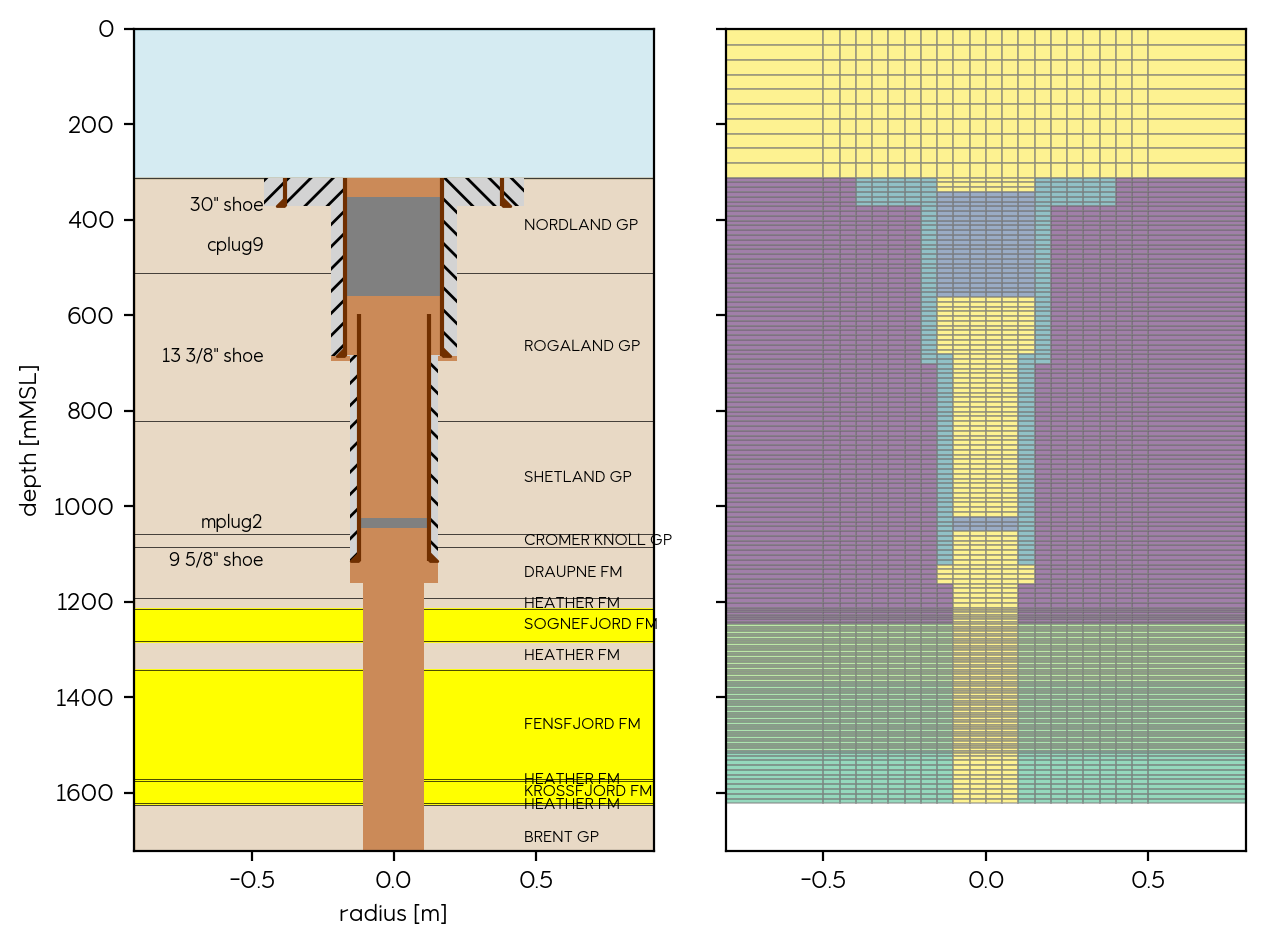

In [86]:

# LGR
XZ_slice = mesh_df.query('j==@mid_i')

# extract permeability value
Z = XZ_slice.PERMX.values.reshape(nz, nx)

# plot it
plot_well_perm(my_well, x=xcorn, y=zcorn, Z=Z, on_coarse=False)


# Write LGR file

In [87]:
output_dir = '.'

In [88]:
# LRG name 
LGR_NAME = 'LEG_HIRES'

In [89]:
casings_df

,top_rkb,bottom_rkb,diameter_in,toc_rkb,boc_rkb,shoe,diameter_m,top_msl,bottom_msl,toc_msl,boc_msl,ann_od_m,ann_bottom_msl,A_i,A_o,thick_m,n_grd_id,k_min,k_max,toc_k_min,toc_k_max,ij_min,ij_max
0,335.5,394.0,30.000,335.5,394.0,True,0.762000,312.0,370.5,312.0,370.5,0.91440,371.5,0.456037,0.656693,0.076200,14,10.0,15.0,10.0,15.0,6.0,19.0
1,335.5,709.0,13.375,335.5,709.0,True,0.339725,312.0,685.5,312.0,685.5,0.44450,696.5,0.090645,0.155179,0.052388,6,10.0,47.0,10.0,47.0,10.0,15.0
2,622.0,1137.5,9.625,706.0,1137.5,True,0.244475,598.5,1114.0,682.5,1114.0,0.31115,1161.5,0.046942,0.076038,0.033337,4,38.0,90.0,47.0,90.0,11.0,14.0


In [90]:
################# Casing #####################

casings_geoms = []
for idx, row in casings_df.iterrows():

    ID = row['diameter_m'] 
    strt_depth, end_depth = row['top_msl'], row['bottom_msl']
    strt_depth_cement, end_depth_cement = row['toc_msl'], row['boc_msl']
    strt_depth_oph, end_depth_oph = drilling_df.loc[idx, ['top_msl', 'bottom_msl']]

    # qc it
    print(idx, ID, strt_depth, end_depth, strt_depth_cement, end_depth_cement, strt_depth_oph, end_depth_oph)
    
    casing_geom = PipeCementModel(ID=ID, 
                                    pipe=DepthModel(strt_depth=strt_depth, end_depth=end_depth, perm=oh_perm),
                                    oph=DepthModel(strt_depth=strt_depth_oph, end_depth=end_depth_oph), 
                                    cement=DepthModel(strt_depth=strt_depth_cement, end_depth=end_depth_cement, perm=cb_perm)
                                 )

    casings_geoms.append(casing_geom)

0 0.762 312.0 370.5 312.0 370.5 312.0 371.5
1 0.339725 312.0 685.5 312.0 685.5 371.5 696.5
2 0.244475 598.5 1114.0 682.5 1114.0 696.5 1161.5


In [91]:
################# Barrier #####################

ib = 0
barriers = []
for idx, row in barriers_mod_df.iterrows():

    ID, strt_depth, end_depth = row['diameter_m'], row['top_msl'], row['bottom_msl']

    # qc it
    print(idx, ID, strt_depth, end_depth)
    
    barrier = ElemModel(ID=ID, 
                        pipe=DepthModel(strt_depth=strt_depth, end_depth=end_depth, perm=barrier_perms[ib])
                       )
    ib = ib + 1
    #
    barriers.append(barrier)



cplug9_0 0.339725 351.5 559.5
mplug2_1 0.244475 1025.5 1045.5


In [92]:
# generate .grdecl file
# TODO(hzh): add 1s to indices here
build_grdecl(output_dir, LGR_NAME,
                casings_geoms,
                barriers,
                LGR_sizes_x, 
                LGR_depths, 
                LGR_numb_z, 
                min_grd_size,
                grid.getNX(), grid.getNY(),
                main_grd_i + 1, main_grd_j + 1,
                main_grd_min_k + 1, main_grd_max_k + 1,
                no_of_layers_in_OB)

...Prints isolating OVB from reservoir keywords in LEG_HIRES.grdecl file
...Prints CARFIN Keywords in LEG_HIRES.grdecl file
...Prints Casings, cement bonds and barrie(s) in LEG_HIRES.grdecl file
...Prints isolating OVB from reservoir in the LGR in LEG_HIRES.grdecl file
Output LGR CARFIN to:  /scratch/SCS/hzh/SCREEN/notebooks/LEG_HIRES.grdecl


In [93]:
!ls -l LEG_HIRES.grdecl*

-rw-rw-r-- 1 hzh scs_ccs 5440 Sep  6 21:33 LEG_HIRES.grdecl
-rw-rw-r-- 1 hzh scs_ccs 5383 Sep  5 19:35 LEG_HIRES.grdecl.smeaheia


In [94]:
# check the results, only compare smeaheia_v1
if case_type == 'smeaheia_v1' and Ali_way:
    !diff LEG_HIRES.grdecl LEG_HIRES.grdecl.smeaheia

32,36c32,36
< PERMX  10000  6  21  6  21  10  16  /
< PERMY  10000  6  21  6  21  10  16  /
< PERMZ  10000  6  21  6  21  10  16  /
< PORO  0.99  6  21  6  21  10  16  /
< SATNUM  2  6  21  6  21  10  16  /
---
> PERMX  10000  6  21  6  21  1  16  /
> PERMY  10000  6  21  6  21  1  16  /
> PERMZ  10000  6  21  6  21  1  16  /
> PORO  0.99  6  21  6  21  1  16  /
> SATNUM  2  6  21  6  21  1  16  /
73,78c73,78
< --pipe with ID of 13.374973249999998 and perm of 10000  were set in LEG_HIRES Local Grid refinement
< PERMX  10000  10  16  10  16  16  48  /
< PERMY  10000  10  16  10  16  16  48  /
< PERMZ  10000  10  16  10  16  16  48  /
< PORO  0.99  10  16  10  16  16  48  /
< SATNUM  2  10  16  10  16  16  48  /
---
> --pipe with ID of 13.373989 and perm of 10000  were set in LEG_HIRES Local Grid refinement
> PERMX  10000  10  16  10  16  10  48  /
> PERMY  10000  10  16  10  16  10  48  /
> PERMZ  10000  10  16  10  16  10  48  /
> PORO  0.99  10  16  10  16  10  48  /
> SATNUM  2  10  